In [1]:
import numpy as np
import scipy
import pylab as mplot
from scipy import interpolate as intrp
from scipy import integrate as intg

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# add NFW with same mass
h0 = 0.7
Om0 = 0.3
z_max = 40./h0
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100*h0, Om0=Om0)
from astropy import units as u

def mass_richness_sv(richness,z):
    #From SV paper
    M_0 = 2.35e14
    lambda_0 = 30.
    z_0 = 0.5
    F = 1.12
    G = 0.11
    #No factors of h
    M200m = M_0*((richness/lambda_0)**F)*((1.+z)/(1.+z_0))**G
    return M200m 

def mass_to_R200m(mass, z, cosmo):
    rho_m_z = cosmo.Om(z)*cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R200m = ((mass_units/(200.*4.*np.pi*rho_m_z/3.))**(1./3.)).to('Mpc')
    return R200m.value

def m200_to_c200_duffy(mass_200, z, h, mean_or_crit_input):
    #Using full (not relaxed)                                                                                                                       
    M_pivot = (2.0e12)/h
    if (mean_or_crit_input == 'crit'):
        A = 5.71
        B = -0.084
        C = -0.47
    if (mean_or_crit_input == 'mean'):
        A = 10.14
        B = -0.081
        C = -1.01
    c_200 = A*((mass_200/M_pivot)**B)*(1.+z)**C
    return c_200

def rho_to_sigma_fast(rr, rho, R_array, h0):
    sigma = np.zeros(len(R_array))
    lnrho_func = intrp.interp1d(np.log(rr), np.log(rho))
    if (1): 
        minz_to_integrate = 0.0
        maxz_to_integrate = z_max
        num_z_tointegrate = 1500
        z_tointegrate = np.linspace(minz_to_integrate, maxz_to_integrate, num = num_z_tointegrate)
        for ri in range(0,len(R_array)):
            func_evals = np.exp(lnrho_func(np.log(np.sqrt(R_array[ri]**2. + z_tointegrate**2.))))
            #twice since integral is symmetric and want -infty to +infty
            sigma[ri] = 2.*intg.simps(func_evals, z_tointegrate)
    return sigma

def Sigma_to_DeltaSigma_fast(R_output, R_Sigma, Sigma, params, minR):

    temp = np.copy(R_Sigma)
    temp[0] *= 0.999999
    temp[-1] *= 1.000001
    sigma_interp_func = intrp.interp1d(np.log(temp), Sigma)
    to_integrate_func = intrp.interp1d(temp, Sigma*R_Sigma)

    dsig = np.zeros(len(R_output))
    for i in range(len(R_output)):
        if (minR < np.min(temp) or np.min(R_output) < np.min(temp)): 
            pdb.set_trace()
        integral_result = intg.quad(to_integrate_func, minR, R_output[i], epsabs=1.0e-03, epsrel=1.0e-03)
        dsig[i] = 2.*(integral_result[0] + params['integral_R_min'])/(R_output[i]**2.) - sigma_interp_func(np.log(R_output[i]))

    return dsig

def NFW(rho_0, r_s, rr):
    rho = (rho_0)/((rr/r_s)*(1.+rr/r_s)**2.)
    return rho

def gNFW(rho_0, r_s, alpha, beta, gamma, rr):
    rho = rho_0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    return rho

def gNFW_delta(rho_0, r_s, alpha, beta, gamma, r_sh, delta, rr):
    rho = rho_0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    rho[rr>=r_sh] *= (rr[rr>=r_sh]/r_sh)**(-delta)     
    return rho

def gNFW_sh(rho_0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, rr):
    rho = rho_0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    rho[rr>=r_sh] *= (rr[rr>=r_sh]/r_sh)**(-delta)*Q_sh        
    return rho

In [3]:
lam = 200.
z = 0.05
M_200 = mass_richness_sv(lam, z)
print("M_200 (no h) = ", M_200)
print("z = ", z)

#Physical
R_200m = mass_to_R200m(M_200, z, cosmo)
c_200m = m200_to_c200_duffy(M_200, z, h0, 'mean')
c_factor = np.log(1.+c_200m) - c_200m/(1.+c_200m)

#Comoving
r_s = (1.+z)*R_200m/c_200m 
rho_0 = M_200/(4.*np.pi*c_factor*r_s**3.) # Msun/Mpc^3 comoving



M_200 (no h) =  1891500395909909.8
z =  0.05


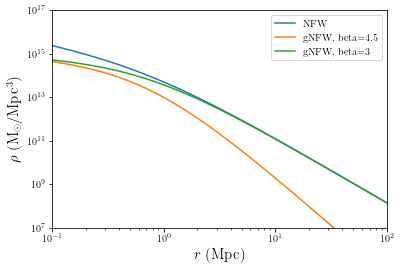

In [4]:
rr = np.exp(np.linspace(np.log(0.0001), np.log(100.0), num = 10000)) # Comoving Mpc
RR = np.exp(np.linspace(np.log(0.01), np.log(50.0), num = 100)) # Comoving Mpc

rho_NFW = NFW(rho_0, r_s, rr)
rho_gNFW1 = gNFW(rho_0, r_s, 1.05, 4.5, 0.23, rr)
rho_gNFW2 = gNFW(rho_0, r_s, 1.05, 3, 0.23, rr)

mplot.loglog(rr, rho_NFW, label='NFW')
mplot.loglog(rr, rho_gNFW1, label='gNFW, beta=4.5')
mplot.loglog(rr, rho_gNFW2, label='gNFW, beta=3')
mplot.xlim(0.1,100)
mplot.ylim(1e7,1e17)
mplot.xlabel('$r \;{\\rm (Mpc)}$', fontsize=15)
mplot.ylabel('$\\rho \;{\\rm (M_{\odot}/Mpc^3)}$', fontsize=15)

mplot.legend()

$\beta=3$ approaches NFW at large $r$. Fix $\alpha, \gamma$ to Hurier values...

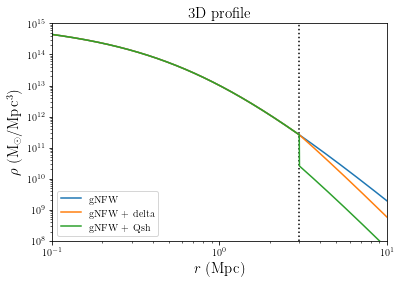

In [5]:
rho_gNFW = gNFW(rho_0, r_s, 1.05, 4.5, 0.23, rr)
rho_gNFW_delta = gNFW_delta(rho_0, r_s, 1.05, 4.5, 0.23, 3., 1., rr)
rho_gNFW_sh = gNFW_sh(rho_0, r_s, 1.05, 4.5, 0.23, 3., 1., 0.1, rr)

mplot.plot([3,3],[1e8,1e15], color='k', ls=':')
mplot.loglog(rr, rho_gNFW, label='gNFW')
mplot.loglog(rr, rho_gNFW_delta, label='gNFW + delta')
mplot.loglog(rr, rho_gNFW_sh, label='gNFW + Qsh')

mplot.xlim(0.1,10)
mplot.ylim(1e8,1e15)
mplot.xlabel('$r \;{\\rm (Mpc)}$', fontsize=15)
mplot.ylabel('$\\rho \;{\\rm (M_{\odot}/Mpc^3)}$', fontsize=15)
mplot.title('3D profile', fontsize=15)
mplot.legend()

In [6]:
sigma_gNFW = rho_to_sigma_fast(rr, rho_gNFW, RR, h0)
sigma_gNFW_delta = rho_to_sigma_fast(rr, rho_gNFW_delta, RR, h0)
sigma_gNFW_sh = rho_to_sigma_fast(rr, rho_gNFW_sh, RR, h0)

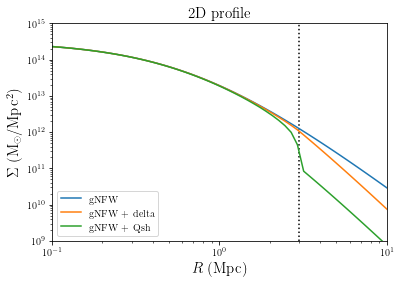

In [7]:
mplot.plot([3,3],[1e9,1e15], color='k', ls=':')
mplot.loglog(RR, sigma_gNFW, label='gNFW')
mplot.loglog(RR, sigma_gNFW_delta, label='gNFW + delta')
mplot.loglog(RR, sigma_gNFW_sh, label='gNFW + Qsh')

mplot.xlim(0.1,10)
mplot.ylim(1e9,1e15)
mplot.xlabel('$R \;{\\rm (Mpc)}$', fontsize=15)
mplot.ylabel('$\Sigma \;{\\rm (M_{\odot}/Mpc^2)}$', fontsize=15)
mplot.title('2D profile', fontsize=15)

mplot.legend()

### Comments:
- there's a small difference doing this in 3D vs. 2D, the sharp features get smeared out
- unclear if the resulting constraints on r_sh will change, needs testing, should get a better idea of the noise in data

### Maxlike fit
        

### Emcee fit